# Chapter 4 - Training Linear Models—训练模型

目前为止，我们将机器学习模型以及它们的训练算法视为黑盒子。如果你经历了前几章的练习，你可能会惊讶于你可以在不了解任何系统内部的情况下，已经完成了：
* 优化回归系统。
* 改进数字图像分类器。
* 从零开始构建一个垃圾邮件分类器。

对于所有的这些，我们都不知道它们实际是如何工作的。在很多情况下，我们不需要知道它们的实施细节。
然而，充分了解事物的工作原理，能够帮助你：
* 快速掌握正确的模型。
* 使用正确的训练算法。
* 为你的具体任务设置一组合适的超参数组合。

除此以外，了解系统如何工作的能够帮助你有效地**调试问题**和**错误分析**，最后，本章讨论的大多数主题对于**理解，构建和训练神经网络**至关重要（在本书的第二部分中讨论）。



在本章中，们将首先研究最简单的**线性回归**模型。我们将讨论两种截然不同的方法来训练它：
* 使用“闭合形式”方程，该方程直接计算最适合训练集的模型的模型参数（即，最小化训练集上的成本函数的模型参数）。
* 使用梯度下降(GD)的迭代优化方法。这种方法逐步调整模型参数以最小化在训练集上成本函数。，最终收敛到与第一种方法相同的参数组合。我们将研究一些梯度下降（GD）的变体，当我们在第二部分研究神经网络时，我们将重复地使用它们：Batch GD，Mini-batch GD和Stochastic GD。 

接下来，我们将了解**多项式回归**。这是一个更复杂的模型，可以适应非线性数据集。由于它具有比线性回归更多的参数，因此更容易对训练数据产生过拟合，因此我们将研究如何使用**学习曲线**检测是否是这种情况，然后我们将研究几种**正则化**技术来降低过拟合训练集的风险。

最后，我们再来看看两个常用于**分类任务**的模型--**Logistic回归**和**Softmax回归**。

## Step

In [1]:
# 只支持 python 3 

import numpy as np
import os

#让笔记能够准确复现
np.random.seed(42)

#导入绘图工具
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#以函数的形式设定图片的保存路径，后续可以直接调用，也可根据个人情况对路径进行修改
PROJECT_ROOT_DIR = "E:\Hands_on_Machine_Learning"  #文件夹
CHAPTER_ID = "Training Models_04" #章节名
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID) #完整路径

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300): #resolution控制分辨率，可修改
    path = os.path.join(IMAGES_PATH,fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout() #子图充满
    plt.savefig(path, format=fig_extension, dpi=resolution)  
    
# 忽略无用警告
import warnings
#warnings.filterwarnings(action="ignore", message="^internal gelsd") # 忽略一部分警告
warnings.filterwarnings("ignore")  #忽略所有警告，谨慎使用

### 4.1 Linear Regression—线性回归
详细的定义和有关参数意义请参考原书**P114-115**,这里简单列出几点：
* 线性模型通过简单地计算输入要素的加权和以及称为偏置项的常数（也称为截距项）对数据进行预测。
* 训练模型意味着设置其参数，以使模型最适合训练集。
* 在第2章中，我们看到回归模型最常见的性能指标是均方根误差（RMSE）（公式2-1）。因此，要训练线性回归模型，你需要找到最小化RMSE的θ值。 在实践中，最小化均方误差（MSE）的计算比RMSE更为简单，且它们计算得到的最终结果相同。


公式4-1 线性回归模型预测：

$\widehat{y} = \theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+\cdots + \theta_{n}x_{n}$
* $\widehat{y}$为预测值。
* $n$为特征数量。
* $x_i$为$i^{th}$特征的值。
* $\theta_{j}$为$j^{th}$模型参数（包括偏置项$\theta_{0}$和特征权值$\theta_{1},\theta_{2},\cdots, \theta_{n}$）。

公式4-2 线性回归模型预测（向量形式）：

$\widehat{y} = h_{\theta}(\mathbf{x}) = \mathbf{\theta}\cdot \mathbf{x}$
* $\mathbf{\theta}$为模型参数向量，包括偏置项$\theta_{0}$和特征权值$\theta_{1},\theta_{2},\cdots, \theta_{n}$。
* $\mathbf{x}$为实例特征向量，包括$x_0$到$x_n$，$x_0$通常为1。
* $ \mathbf{\theta}\cdot \mathbf{x}$为向量$ \mathbf{\theta}$和$ \mathbf{x}$的点积，与$\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+\cdots + \theta_{n}x_{n}$相等。
* $h_{\theta}$为与模型参数$\mathbf{\theta}$有关的假设函数。

公式4-3 用于线性回归模型的MSE成本函数：

$\operatorname{MSE}\left(\mathbf{X}, h_{\theta}\right)=\frac{1}{m} \sum_{i=1}^{m}\left(\boldsymbol{\theta}^{T} \mathbf{x}^{(i)}-y^{(i)}\right)^{2}$

在第二章中已有详细介绍，这里不再赘述。

#### 4.1.1 The Normal Equation-正规矩阵

为了找到最小化成本函数的参数θ的取值。有一种封闭形式的解决方案， 换句话说，一个直接计算出结果的数学方程式。 这就是所谓的正规方程（公式4-4）。

公式4-4 正规方程：

$\widehat{\theta} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T} y $
* $\widehat{\theta}$为使成本函数取最小值时对应的$\theta$的取值。
* $y$为目标值向量，从$y^{(1)}$到$y^{(m)}。

生成一些线性外观数据来测试这个等式（图4-1）：

In [2]:
X=2*np.random.rand(100,1)  # 0-2生成100个数据
y=4+3*X+np.random.randn(100,1) # 为了模拟实际情况，加上一点噪声

Saving figure generated_data_plot


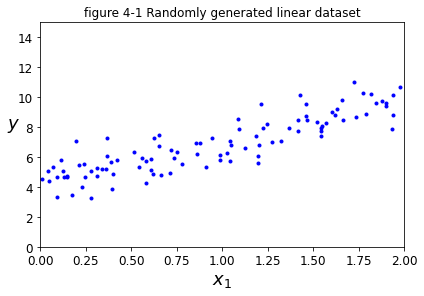

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot") 
plt.title('figure 4-1 Randomly generated linear dataset')
plt.show()

现在让我们使用Normal Equation计算θ。我们将使用NumPy的线性代数模块（**np.linalg**）中的**inv（）函数**来计算矩阵的逆，以及用于矩阵乘法的**dot（）函数**：

In [4]:
X_b=np.c_[np.ones((100,1)),X]  #对每个实例，使得x0=1 ，因为偏置项b和参数w放在同一个向量中
theta_best=np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

我们用于生成数据的实际函数是y = 4 + 3x 0 +高斯噪声( y = 4 + 3x 0 + Gaussian noise.)让我们看看等式找到了什么：

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

我们希望$\theta_{0}=4$且$\theta_{1}=3$，而不是$\theta_{0}=4.22$且$\theta_{1}=2.77$。虽然足够接近，但是噪音使得无法恢复原始函数的确切参数。

现在我们可以使用${\theta}$进行预测：

In [6]:
X_new=np.array([[0],[2]])
X_new_b=np.c_[np.ones((2,1)),X_new] #对每个实例，使得x0=1 ，因为偏置项b和参数w放在同一个向量中
y_predict=X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

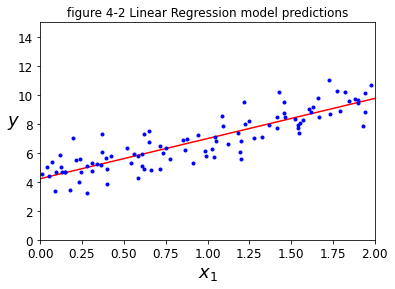

In [7]:
plt.plot(X_new,y_predict,"r-")
plt.plot(X,y,"b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.title('figure 4-2 Linear Regression model predictions')
plt.show()

使用Scikit-Learn的等效代码如下所示:

In [8]:
#从sklearn库中导入线性回归类
from sklearn.linear_model import LinearRegression 

lin_reg = LinearRegression()
lin_reg.fit(X, y)  #开始拟合
lin_reg.intercept_, lin_reg.coef_  # .intercept为偏置项，.coef为权重

(array([4.21509616]), array([[2.77011339]]))

In [9]:
lin_reg.predict(X_new) #用于预测，LinearRegression中自带偏置，因此不需要使得 x0=1

array([[4.21509616],
       [9.75532293]])

LinearRegression类基于scipy.linalg.lstsq（）函数（名称代表“**最小二乘**”），可以直接调用它：

In [10]:
import scipy
theta_best_svd, residuals, rank, s = scipy.linalg.lstsq(X_b, y)
theta_best_svd

#书中存在问题，前文写的是用scipy.linalg.lstsq（）函数求参数
#但是代码中使用的是np.linalg.lstsq（）,
#两个函数求得的参数结果一样，但是调用时，传入的参数略有不同

array([[4.21509616],
       [2.77011339]])

这个函数计算$\widehat{\boldsymbol{\theta}}=\mathbf{X}^{+} \mathbf{y}$，其中，$\mathbf{X}^{+}$为$\mathbf{X}$的伪逆（特别是穆尔-彭罗斯广义逆）。你也可以使用np.linalg.pinv()直接计算伪逆：

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

伪逆本身通过奇异值分解（SVD）计算得到。奇异值分解将训练集矩阵$\mathbf{X}$分解为三个矩阵$\mathbf{U} \quad \Sigma \quad \mathbf{V}^{T}$的乘积。伪逆计算为$\mathbf{X}^{+} = \mathbf{V}  \Sigma^{+}  \mathbf{U}^{T} $。为了计算矩阵$\Sigma^{+}$，将矩阵$\Sigma$中小于阈值的元素值都置为0，将其余的非零元素替换为它们的逆，最后将矩阵进行转置。这个方法比计算正规矩阵有更高的效率，且能更好地处理特殊情况：当矩阵$\mathbf{X}^{+}\mathbf{X}$不可逆时，比如$m<n$或者特征数量比较多，正规矩阵可能不起作用。但是伪逆一直存在。

#### 4.1.2 Computational Complexity-计算复杂度
正规矩阵计算$\mathbf{X}^{+}\mathbf{X}$的逆（$(n+1)\times(n+1)$，$n$为特征数量。计算这种矩阵逆的时间复杂度通常为$O(n^{2.4})$到$O(n^{3})$（取决于具体实施）。也就是说，如果对特征数量进行翻倍，计算时间大概需要乘以$2^{2.4}=5.3$到$2^{3}=8$

Skit-Learn中LinearRegression类使用的SVD方法的时间复杂度为$O(n^2)$。如果特征数量翻倍，计算时间大概需要乘以4.

当特征数量变大时，正规方程和SVD方法都会变慢。从积极的方面来说，The Normal Equation关于训练集中的实例数是线性的（它是$O(m)$），因此它可以有效地处理大型训练集，只要它们能够适合内存。

此外，一旦ni1训练了线性回归模型（使用正规方程或任何其他算法），预测会非常快：计算复杂度与您想要进行预测的实例数量和特征数量都是线性的。 换句话说，对两倍的实例（或两倍的特征）进行预测只需要大约两倍的时间。

现在我们使用一个非常不同的方法来训练线性回归模型，更好适用于有大量特征或训练太多实例的情况。

### 4.2  Gradient Descent-梯度下降

**梯度下降**是一种非常通用的优化算法，能够找到解决各种问题的最佳解决方案。梯度下降的一般思想是：**迭代调整参数以最小化成本函数**。

假设你在浓雾中迷失在山里;你只能感觉到脚下的地面坡度。快速到达山谷底部的一个好策略是沿最陡坡的方向下坡。这正是梯度下降所作的：它计算误差函数关于参数向量$\theta$的局部梯度,并且它沿着下降梯度的方向。一旦梯度为零，意味着达到了最低限度！

具体来说，你：
* 首先用随机值对$\theta$进行赋值（这称为随机初始化）
* 然后你逐步改进它，每次迈出一步，每一步试图降低成本函数（例如，MSE），直到算法收敛到最小值（见图4-3）。



![image-20200718194327054](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/18/194328-447791.png)

梯度下降中的一个重要参数是**步长的大小**，由**学习速率超参数**确定。 如果学习速率太小，那么算法将不得不经历多次迭代以收敛，这将花费很长时间（见图4-4）。
![image-20200718194430243](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/18/194432-459171.png)

另一方面，如果学习率太高，你可能会跳过山谷并最终在另一边，甚至可能比以前更高。这可能会使算法出现分歧，值越来越大，无法找到一个好的解决方案（见图4-5）。
![image-20200718194538695](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/18/194541-572577.png)

最后，并非所有成本函数看起来都像普通的碗状。可能存在洞，山脊，高原和各种不规则的地形，使收敛到最小值* 非常困难。 图4-6显示了梯度下降的两个主要挑战：
* 如果随机初始化在左侧启动算法，那么它将收敛到局部最小值，这不如全局最小值。 
* 如果它从右边开始，则需要很长时间才能越过高原，如果你太早停止，你永远不会达到全局最小值。

![image-20200718194618899](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/18/194620-410036.png)

幸运的是，线性回归模型的MSE成本函数恰好是**凸函数**，这意味着：

* 如果在曲线上选取任意两个点，则连接它们的线段永远不会越过曲线。
* 没有局部最小值，只有一个全局最小值。 它也是一个连续的函数，其斜率永远不会突变。

这两个性质有非常好的结果：梯度下降保证接近任意**全局最小值**（如果你等待的时间足够长，如果学习率不是太高）。

事实上，成本函数具有碗的形状，但如果特征具有非常不同的尺度，它可以是一个细长的碗。图4-7显示：
* 训练集上的梯度下降，其中特征1和2具有相同的比例（左侧）
* 并且在训练集上，特征1的值比特征2（右侧）小得多

![image-20200718194659394](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/18/194724-33782.png)

如你所看到的：
* 在左侧，梯度下降算法直接向最小值方向移动，从而快速到达这个最小值
* 而在右侧，它首先沿与全局最小值方向几乎正交的方向前进，并以最接近平坦谷的长行程结束。 它最终会达到最低限度，但需要很长时间。

**注意**：使用梯度下降时，应确保所有特征具有相似的比例（例如，使用Scikit-Learn的StandardScaler类），否则收敛时间会更长。

该图还说明了这一事实：训练模型意味着搜索最小化成本函数的模型参数的组合（在训练集上）。

它是模型参数空间中的一个搜索：模型具有的参数越多，该空间的维数越多，搜索越难：在300维草堆中搜索一根针比在三维中更棘手。 幸运的是，由于在线性回归的情况下**成本函数是凸的**，因此针只是在碗的底部而已。

#### 4.2.1 Batch Gradient Descent—批量梯度下降法
要实现梯度下降，你需要根据每个模型参数$\theta_j$计算成本函数的梯度。 换句话说，稍微更改$\theta_j$，计算成本函数的变化量。这被称为**偏导数**。 这就像问“如果我面向东方，我的脚下的山坡是什么？”然后问北面的相同问题（如果可以想象一个超过三维的宇宙，那么所有其他维度都是如此）。
公式4-5计算了关于参数$\theta_j$的成本函数的偏导数$\frac{∂}{∂\theta_j}MSE(\theta)$:

公式4-5 成本函数的偏导数：

$\frac{\partial}{\partial \theta_{j}} \operatorname{MSE}(\theta)=\frac{2}{m} \sum_{i=1}^{m}\left(\theta^{T} \cdot \mathbf{x}^{(i)}-y^{(i)}\right) x_{j}^{(i)}$

可以使用公式4-6来代替单独计算这些梯度一口气把它们全都搞定。 **标记为$∇_{\theta} MSE(\theta)$的梯度向量**包含成本函数的所有偏导数（每个模型参数一个:

$\nabla_{\theta} \operatorname{MSE}(\theta)=\left|\begin{array}{c}\frac{\partial}{\partial \theta_{0}} \operatorname{MSE}(\theta) \\ \frac{\partial}{\partial \theta_{1}} \operatorname{MSE}(\theta) \\ \vdots \\ \frac{\partial}{\partial \theta_{n}} \operatorname{MSE}(\theta)\end{array}\right|=\frac{2}{m} \mathbf{x}^{T} \cdot(\mathbf{X} \cdot \theta-\mathbf{y})$

请注意，**此公式涉及在每个Gradient Descent步骤中对完整训练集X的计算**！ 这就是为什么算法被称为**批量梯度下降**：它在每一步使用整批训练数据。 因此，在非常大的训练集上它非常慢（不过我们很快就会看到更快的Gradient Descent算法）。但是，梯度下降与特征数量的关系匹配的很好; 当使用数十万个特征训练线性回归模型时，梯度下降比正规矩阵和SVD分解要快得多

一旦你有了上坡的梯度向量，走向相反的方向就是去下坡。 这意味着从$\theta 减去∇_\theta MSE(\theta)$。 这是学习速率$η$发挥作用的地方：将梯度向量乘以$η$以确定下坡步长的大小（公式4-7）：

$\theta^{(\text {next step })}=\theta-\eta \nabla_{\theta} \operatorname{MSE}(\theta)$


In [12]:
eta = 0.1 #学习率
n_iteration = 1000 #迭代次数
m = 100 #数据数量
theta = np.random.randn(2,1) #随机初始化模型参数

for iteration in range(n_iteration):
    gradients = 2/m*X_b.T.dot(X_b.dot(theta)-y)  #计算梯度
    theta = theta-eta*gradients  #更新参数

In [13]:
theta

array([[4.21509616],
       [2.77011339]])

In [14]:
theta_path_bgd = []  #记录梯度下降过程

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000  # 迭代次数
    for iteration in range(n_iterations):
        if iteration < 10:  # 画出前10个 epoch 梯度下降结果
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


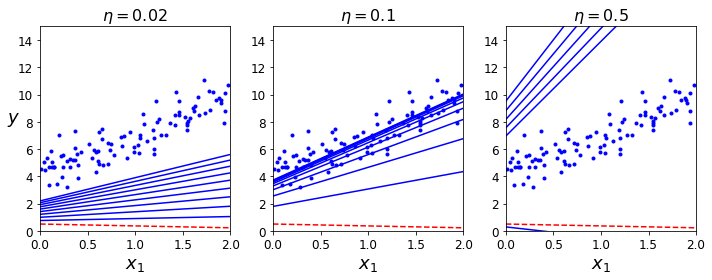

In [15]:
np.random.seed(42)
theta = np.random.randn(2,1)  # 随机初始化

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

这正是Normal Equation找到的！梯度下降工作完美。 但是如果你使用了**不同的学习率eta**怎么办？ 图4-8显示了使用三种不同学习率的梯度下降的前10个步骤（虚线表示起点）。

* 左边，学习率过低：算法最终会得到最优解，但是耗费很长的时间。
* 中间，学习率看起来非常好，只经过几次迭代，就能接近最优解。
* 右边，学习率过高，算法发散，直接跳过了数据区域，并且每一步都离最优解越来越远。

要找到良好的学习率，您可以使用**网格搜索**（请参阅第2章）。但是，你可能希望限制迭代次数，以便网格搜索可以淘汰需要太长时间才能收敛的模型。

你可能想知道如何设置迭代次数。如果它太低，当算法停止时你可能远没有达到最佳解决方案，但如果它太高，你将浪费时间，而模型参数不再变化。

一个简单的解决方案是设置非常大量的迭代，但是**当梯度向量变得很小时中断算法** -，也就是说，当它的范数变得小于一个微小数量**ε（称为公差）**时 ---因为当梯度下降（几乎）达到最小值时会发生这种情况

**Convergence Rate-收敛速度**:

当成本函数是凸的并且其斜率不会突然改变时（就像是MSE成本函数的情况），可以证明，具有固定学习速率的批量梯度下降具有$O(\frac{1}{iterations})$的收敛速度。 换句话说，如果将**公差ε除以10**（以获得更精确的解），则算法必须运行大约10倍的迭代次数。

#### 4.2.2 Stochastic Gradient Descent—随机梯度下降法
Batch Gradient Descent的主要问题是它使用整个训练集来计算每一步的梯度，这使得训练集很大时，训练速度非常慢。在相反的极端，随机梯度下降只是在每一步中在训练集中选择一个随机实例，并仅根据该单个实例计算梯度。显然，这使得算法更快，因为它在每次迭代时都只有很少的数据可操作。它还可以训练大量训练集，因为每次迭代只需要一个实例存储在内存中（SGD可以实现为核外算法）

另一方面，由于其随机（即随机）性质，这种算法比批量梯度下降更不规则：成本函数不会逐渐下降直到达到最小值，而是会反复上下跳动，只是平均下降。随着时间的推移，它将最终接近最小值，但一旦到达那里它就会继续反弹，永不安定下来（见图4-9）。因此，一旦算法停止，最终参数值是好的，但不是最佳的。
![image-20200719203017893](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/19/203021-743339.png)

当成本函数非常不规则时（如图4-6所示），这实际上可以帮助算法跳出局部最小值，因此随机梯度下降比批量梯度下降更容易找到全局最小值。因此，随机性有利于摆脱局部最优，但不利的是这意味着算法永远无法到达最低值。这种困境的一个解决方案是**逐渐降低学习率**。步长开始很大（这有助于快速处理并逃离局部最小值），然后变得越来越小，使得算法稳定在全局最小值。这个过程称为**模拟退火**，因为它类似于冶金中的退火过程，其中熔融金属被缓慢冷却。**确定每次迭代学习速率的函数称为学习计划**。
* 如果学习速度降低太快，您可能会陷入局部最小值，甚至最终冻结在寻找最低限度的过程中。
* 如果学习速度降低得太慢，您可能会长时间跳到最小值，如果过早停止训练，最终会得到次优解决方案。

此代码使用简单的学习计划实现随机梯度下降：

In [16]:
theta_path_sgd = [] #记录SGD过程
m = len(X_b)   #数据集大小
np.random.seed(42)

Saving figure sgd_plot


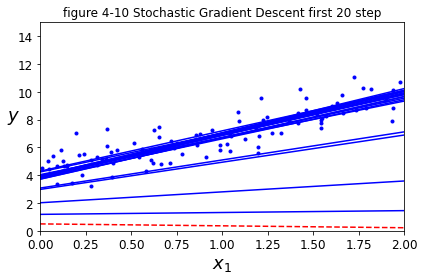

In [17]:
n_epochs = 50  # 迭代次数
t0, t1 = 5, 50 # 学习过程超参数

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1) #随机初始化

for epoch in range(n_epochs):
    for i in range(m):
        if epoch ==0 and i <20:  #在这里设置显示的轮数，可以更改
            y_predict = X_new_b.dot(theta)
            style = "b-" if i>0 else "r--"
            plt.plot(X_new, y_predict, style) #画图
            
        random_index = np.random.randint(m)  #随机抽取样本
        xi=X_b[random_index:random_index+1]
        yi=y[random_index:random_index+1]
        gradients=2*xi.T.dot(xi.dot(theta)-yi)  #计算梯度
        eta=learning_schedule(epoch*m+i)
        theta=theta-eta*gradients
        theta_path_sgd.append(theta)
        
plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])  
plt.title('figure 4-10 Stochastic Gradient Descent first 20 step')
save_fig("sgd_plot") 

plt.show()  

上图显示了训练的前20步（注意步骤的不规则程度）。

按照惯例，我们迭代m次循环; 每一轮被称为一个epoch。而Batch Gradient Descent代码在整个过程中迭代了1,000次训练集，此代码仅通过训练集50次，并达到一个相当不错的解：

In [18]:
theta

array([[4.21076011],
       [2.74856079]])

请注意，由于实例是随机挑选的，因此某些实例可能会在每个epoch被挑选几次，而其他实例可能根本不会被挑选。 如果你想确保算法遍历每个epoch的每个实例，另一种方法是对训练集进行打乱，然后逐个实例化，然后再次将其打乱，依此类推。 然而，这通常会收敛得更慢。

当使用 SGD 时，训练数据必须使独立同分布(IID）,以确保参数平均地被拉向全局最优。确保这一点的一个简单方法是在训练过程中对实例进行shuffle（例如，随机选取每个实例，或者在每个 epoch 开始时对训练集进行 shuffle）。如果你不这样做，例如如果实例是按标签排序的，那么SGD就会从优化一个标签开始，然后是下一个标签，以此类推，它不会稳定在接近全局最小值的位置。

要使用SGD和Scikit-Learn执行线性回归，您可以使用**SGDRegressor**类，默认为优化**平方误差成本函数**。以下代码最多运行1000个epochs，或者直到 loss 在某个 epoch 小于1e-3(tol = 1e-3)。从学习率0.1（eta0 = 0.1）开始，使用默认学习计划（与前一个不同），并且它不使用任何正则化（惩罚项=无;后面会有关于此的更多细节）：

In [19]:
from sklearn.linear_model import SGDRegressor  #导入相关类

sgd_reg=SGDRegressor(max_iter=50,tol = 1e-3, penalty=None,eta0=0.1)  #设置SGD过程中的一些参数
sgd_reg.fit(X,y.ravel())

SGDRegressor(eta0=0.1, max_iter=50, penalty=None)

In [20]:
sgd_reg.intercept_,sgd_reg.coef_ # .intercept为偏置项，.coef为权重

(array([4.23868557]), array([2.82181634]))

#### 4.2.3 Mini-batch Gradient Descent—小批量梯度下降法

在每一步，不是基于完整的训练集（如在批处理GD中）或仅基于一个实例（如在随机GD中）计算梯度，Mini-batch Gradient Descent在一个小的随机训练集计算梯度。 与Stochastic GD相比，Mini-batch GD的主要优势在于：我们可以通过矩阵操作的硬件优化获得性能提升，尤其是在使用GPU时。

In [21]:
theta_path_mgd = []  #记录梯度下降过程

n_iterations = 50   #设置迭代轮数
minibatch_size = 20  #设置 batch_size大小

np.random.seed(42)
theta = np.random.randn(2,1)  # 随机初始化

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)   # 设置学习率衰减规则

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)  #随机打乱
    X_b_shuffled = X_b[shuffled_indices]  #随机打乱数据
    y_shuffled = y[shuffled_indices]

    for i in range(0, m, minibatch_size):  #循环完一次
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [22]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [23]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


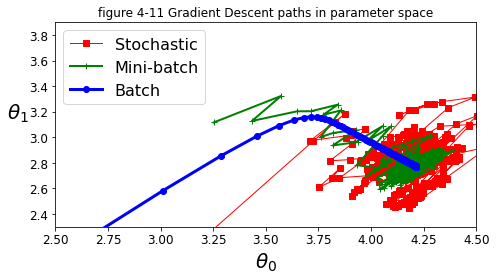

In [24]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.title('figure 4-11 Gradient Descent paths in parameter space')
save_fig("gradient_descent_paths_plot")
plt.show()

与 SGD 相比，算法在参数空间更加稳定尤其是在相当大的 mini-batches下。因此，Mini-batch GD最终会比SGD更接近最小值。但另一方面，它可能更难摆脱局部最小值（在遭受局部最小值的问题上，不同于我们前面看到的线性回归）。图4-11 展示了三种梯度下降算法在参数空间的路径。它们最后都接近最小值，但是 Batch GD的路径是停在了最小值，而  Stochastic GD 和 Mini-batch GD 依然在震荡。但不要忘记了 Batch GD 每一步都花费大量时间。如果你采用好的学习计划，Stochastic GD 和 Mini-batch GD 也会到达最小值。

让我们来对比一下我们目前为止讨论过的线性回归，见表 4-1：
![image-20200719220002007](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/19/220003-754743.png)
在训练之后，几乎没有区别。这些算法都会得到相似的模型，并 以完全相同的方式进行预测。

### 4.2-a. Polynomial Regression—多项式回归

如果你的数据实际上比简单的直线更复杂怎么办？令人惊讶的是，您实际上可以**使用线性模型来拟合非线性数据**。 一种简单的方法是为每个特征添加权重做为新特征，然后在这组扩展特征上训练线性模型。 这种技术称为**多项式回归**。

我们来看一个例子。 首先，让我们基于一个简单的二次方程生成一些非线性数据（加上一些噪声;见图4-12）：

Saving figure quadratic_data_plot


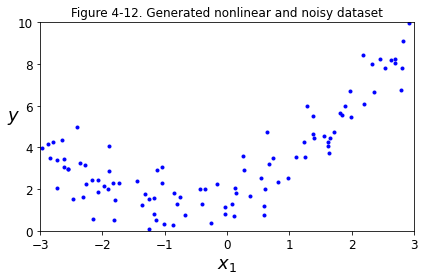

In [25]:
#与之前生成线性数据一样
import numpy as np
import numpy.random as rnd

np.random.seed(42)

m=100
X=6*np.random.rand(m,1)-3
y=0.5*X**2+X+2+np.random.randn(m,1)

plt.plot(X, y, "b.")
plt.title('Figure 4-12. Generated nonlinear and noisy dataset')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

显然，直线永远不会拟合这些数据。因此，让我们使用Scikit-Learn的Poly nomialFeatures类来转换我们的训练数据，将训练集中**每个特征的平方**（二次多项式）添加为新特征（在这种情况下只有一个特征）：

In [26]:
from sklearn.preprocessing import PolynomialFeatures  #导入相关的类

poly_features=PolynomialFeatures(degree=2,include_bias=False)  #设置类参数
X_poly=poly_features.fit_transform(X)  #开始拟合
X[0]

array([-0.75275929])

In [27]:
X_poly[0]  # X[0] 和 X[0]平方的值

array([-0.75275929,  0.56664654])

X_poly现在包含X的原始特征加上此特征的平方。现在，你可以将LinearRegression模型拟合到此扩展训练数据中（图4-13）：

In [28]:
lin_reg=LinearRegression()
lin_reg.fit(X_poly,y) # 必须是 X_poly
lin_reg.intercept_,lin_reg.coef_ # .intercept为偏置，.coef为权重

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


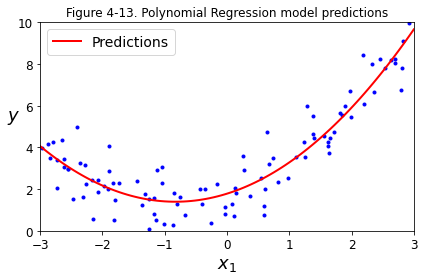

In [29]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)  #表示多项式的一些参数
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.title('Figure 4-13. Polynomial Regression model predictions') # 书中没有
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

还不错：模型估计的$y_{hat} = 0.56x_1^2+ 0.93x_1 + 1.78$实际上的原始函数是$y = 0.5x_1^2+ 1.0x_1 + 2.0 +高斯噪声$。

请注意，当有多个特征时，多项式回归能够找到特征之间的关系（这是普通线性回归模型无法做到的）。 这是因为PolynomialFeatures还添加了特定次数的所有特征组合。 例如，如果有两个特征a和b，则degree= 3的多项式特征不仅会添加特征$a^2，a^3，b^2和b^3$，还会添加组合$ab，a^2 b和ab^2$

**PolynomialFeatures（degree = d）将包含$n$个特征的数组转换为包含$\frac{(n + d)！}{d！n!}$特征的数组，其中$n！$是$n$的阶乘，等于$1×2×3×⋯×n$。 注意特征数量的组合爆炸！**

### 4.2-b. Learning Curves—学习曲线

如果你执行高次多项式回归，可能比使用简单线性回归更好地拟合训练数据。例如，图4-14将300次多项式模型应用于前面的训练数据，并将结果与纯线性模型和二次模型（ 二次多项式）进行比较。**注意300次多项式模型是如何震荡以尽可能接近训练实例**。

Saving figure high_degree_polynomials_plot


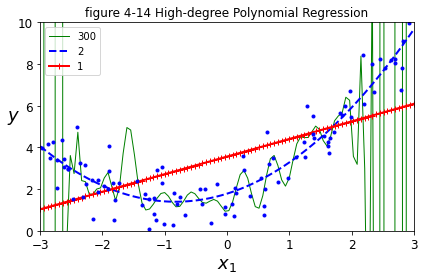

In [30]:
from sklearn.preprocessing import StandardScaler  # 标准化类
from sklearn.pipeline import Pipeline    #将操作集合，放到一起

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)#拟合
    y_newbig = polynomial_regression.predict(X_new) #预测
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.title('figure 4-14 High-degree Polynomial Regression')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

当然，这种高次多项式回归模型严重过拟合训练数据，而线性模型则欠拟合。在这种情况下泛化最好的模型是二次模型。 这是有道理的，因为数据是使用二次模型生成的，但通常我们不会知道生成数据的函数是什么，**那么如何判断模型应该有多复杂？ 如何判断模型是否过拟合或欠拟合？**

在第2章，我们使用**交叉验证**来估计模型的泛化性能：
* 如果模型在训练数据上表现良好，但根据交叉验证指标泛化不佳，那么模型就是**过拟合**了。
* 如果两者都表现不佳，那么它就是**欠拟合**。

这是判断模型过于简单或过于复杂的一种方法。

另一种方法是查看学习曲线：
* 这些图反映的是**模型在训练集上和验证集上的表现关于训练集大小的函数**

要生成学习曲线，只需在训练集的不同大小的子集上多次训练模型。 以下代码定义了一个函数，该函数在给定一些训练数据的情况下绘制模型的学习曲线：

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split  # 分割类，将原始的数据集分为 train 和 test两部分

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 10 ) # 开始分割，test占比20% ， random_state表示随机种子
    train_errors, val_errors = [], []               
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m]) #在不同的大小的训练集中训练
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 书中没有
    plt.xlabel("Training set size", fontsize=14) # 书中没有
    plt.ylabel("RMSE", fontsize=14)              # 书中没有


Saving figure underfitting_learning_curves_plot


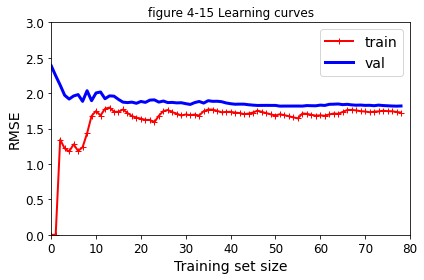

In [32]:
lin_reg = LinearRegression() #模型为回归模型
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # 书中没有
plt.title('figure 4-15 Learning curves')        # 书中没有
save_fig("underfitting_learning_curves_plot")   # 书中没有

* 首先，让我们看一下训练数据的表现：当训练集中**只有一个或两个**实例时，模型可以完美地拟合它们，这就是曲线**从零开始**的原因。但是随着新实例被添加到训练集中，模型不可能完美地拟合训练数据，因为数据是嘈杂的，并且因为它根本不是线性的。因此，训练数据的误差一直持续到达到**稳定状态**，此时向训练集添加新实例不会使平均误差更好或更差。

* 其次让我们看一下模型在验证数据上的性能。当模型在极少数训练实例上训练时，它无法正确推广泛化，这就是验证错误**最初非常大**的原因。 然后，当模型显示更多训练样例时，它会学习，因此**验证错误会慢慢下降**。然而，直线无法很好地对数据进行建模，因此**误差最终处于平稳状态**，非常接近另一条曲线。

这些学习曲线是典型的欠拟合模型。两条曲线都达到了稳定水平;它们很接近而且相当高。如果你的模型不适合训练数据，添加更多训练数据将无济于事。你需要**使用更复杂的模型或提出更好的特征**。

现在让我们看一下相同数据的第10次多项式模型的学习曲线（图4-16）：  

Saving figure learning_curves_plot


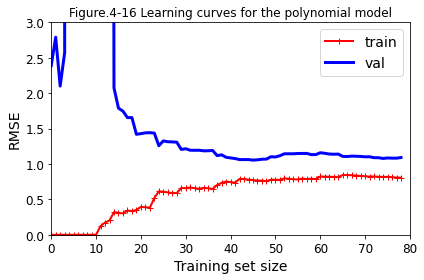

In [33]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])  # 书中没有
plt.title('Figure.4-16 Learning curves for the polynomial model')
save_fig("learning_curves_plot")  # 书中没有
plt.show()

这些学习曲线看起来有点像以前的那些，但有两个非常重要的差异：
* 训练数据的误差远低于线性回归模型。
* 曲线之间存在间隙。这意味着**模型在训练数据上的表现明显优于验证数据**，验证数据是过拟合模型的标志。 但是，如果您使用了更大的训练集，则两条曲线将继续靠近。**改进过拟合模型**的一种方法是向其提供**更多训练数据**，直到验证错误达到训练误差。

#### 偏差/方差的权衡
统计机器学习的一个重要理论结果是模型的泛化错误事实上可以表示为三个非常不同的错误的总和：

**Bias-偏差**

这部分泛化错误是由于错误的假设，例如假设数据实际上是二次数时是线性的。 高偏差模型最有可能欠拟合训练数据。

**Variance-方差**

这部分是由于模型对训练数据中的小变化过度敏感。 具有更高次数的模型（例如高次多项式模型）可能具有高方差，因此过拟合训练数据。

**Irreducible error-不可避免的错误**

这部分是由于数据本身的噪音。 减少这部分错误的唯一方法是**清洗数据**（例如，修复数据源，例如损坏的传感器，或检测并删除异常值）。

**增加模型的复杂性通常会增加其方差并减少其偏差**。相反，**降低模型的复杂性会增加其偏差并减少其方差**。 这就是它被称为权衡的原因。

### 4.3 Regularized Linear Models—正则线性模型

正如我们在第1章和第2章中看到的，**减少过拟合的一个好方法是使模型正则化**（即约束它）：它具有的自由度越小，它就越难以过拟合数据。例如
* 规范多项式模型的简单方法是减少多项式度数。

对于线性模型，通常通过约束模型的权重来实现正则化。我们现在来看看**岭回归(Ridge Regression)，套索回归( Lasso Regression)和弹性网络(Elastic Net)**，它们实现了三种不同的方式来约束权重。

#### 4.3.1 Ridge Regression—岭回归

**岭回归（也称为Tikhonov正则化）**是线性回归的正则化版本：将等于$αΣ_{i=1}^nθ_i^2$的正则化项添加到损失函数中。这迫使学习算法不仅适合数据而且保持模型权重尽可能小。请注意，**正则化项只应在训练期间添加到损失函数**中。 训练模型后，您需要使用未经规范的性能度量来评估模型的性能。

在训练期间使用的成本函数与用于测试的性能度量不同是很常见的。除了正则化，它们可能不同的另一个原因是训练良好的成本函数应该具有优化友好的衍生物，而用于测试的性能测量应该尽可能接近最终目标。一个很好的例子是使用成本函数训练的分类器，例如对数损失（马上在后面讨论），但使用精确/召回进行评估。

超参数α控制我们想要对模型进行规范化的程度。 
* 如果$α= 0$，那么岭回归就是线性回归。 
* 如果$α$非常大，则所有权重最终都非常接近于零，结果是一条平坦的线条通过数据的均值

公式4-8显示了岭回归成本函数:

$J(\boldsymbol{\theta})=\operatorname{MSE}(\boldsymbol{\theta})+\alpha \frac{1}{2} \sum_{i=1}^{n} \theta_{i}^{2}$

注意，偏差项$θ_0$不能被正则化（总和从$i = 1$开始，而不是0）。如果我们将$w$定义为特征权重$(θ_1到θ_n)$的向量，则正则化项简单地等于$\frac{1}{2}(∥w∥_2)^2$，其中$∥·∥_2$表示权向量的$L_2$范数。对于梯度下降，只需将$αw$添加到MSE梯度向量（公式4-6）

在执行岭回归之前进行缩放数据（例如，使用StandardScaler）很重要，因为它对输入要素的比例很敏感。 大多数正规化模型都是如此。

Saving figure ridge_regression_plot


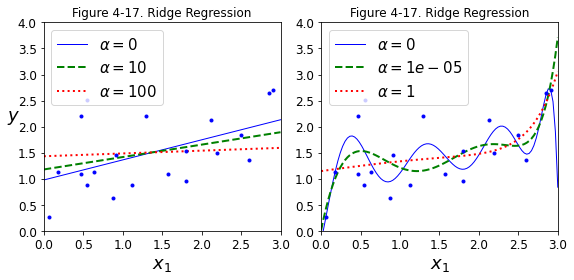

In [34]:
from sklearn.linear_model import Ridge  # 导入 岭回归类

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-","g--","r:")): #令 alphas 与 style一一对应
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()#选择回归模型
        if polynomial:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("regul_reg", model),
            ])
            
        model.fit(X,y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1 #设置线宽度
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

    
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('Figure 4-17. Ridge Regression') # 书中没有
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plt.title('Figure 4-17. Ridge Regression') # 书中没有
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)


save_fig("ridge_regression_plot")
plt.show()
           

图4-17显示了使用不同$α$值对一些线性数据进行训练的几个Ridge模型。 
* 在左侧，使用普通的Ridge模型，导致线性预测。
* 在右侧，首先使用PolynomialFeatures（degree = 10）扩展数据，然后使用StandardScaler对其进行缩放，最后将Ridge模型应用于结果特征：这是具有岭正则化的多项式回归。

注意增加$α$如何导致更平坦（即，更不极端，更合理）的预测; 这减少了模型的方差，但增加了偏差。

与线性回归一样，可以通过闭式方程或执行梯度下降。 优点和缺点是相同。 等式4-9显示出了闭合形式的解（其中**A**是$(n+1)×(n+1)$**单位矩阵**，除了左上角单元中的0，对应于偏置项）。

公式 4-9 岭回归的闭式解：

$\widehat{\theta} = (\mathbf{X}^{T}\mathbf{X}+ \alpha \mathbf{A})^{-1}\mathbf{X}^{T} y $


以下是通过Scikit-Learn使用闭形式解决方案（使用André-Louis Cholesky-楚列斯基的矩阵分解技术的公式4-9的变体）执行岭回归的方法：

In [35]:
from sklearn.linear_model import Ridge

ridge_reg=Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]]) #预测

array([[1.55071465]])

使用随机梯度下降：

In [36]:
sgd_reg=SGDRegressor(penalty="l2") #带l2正则化项的SGD
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([1.46543286])

超参数' penalty'设置要使用的正则化项的类型。指定“l2”表示我们**希望SGD将正则化项添加到成本函数中**，该成本函数等于权重向量的ℓ2范数的平方的一半：这只是岭回归。

#### 4.3.2 Lasso Regression—Lasso回归

**最小绝对收缩和选择算子回归（简称为Lasso回归）**是线性回归的另一个正则化版本：就像岭回归一样，它在成本函数中增加了一个正则项，但它使用了权重向量的$l_1$范数而不是$l_2$范数的一半平方 （见公式4-10）:

公式 4-10 Lasso 回归成本函数：
$J(\boldsymbol{\theta})=\operatorname{MSE}(\boldsymbol{\theta})+\alpha  \sum_{i=1}^{n} |\theta_{i}|$


Saving figure lasso_regression_plot


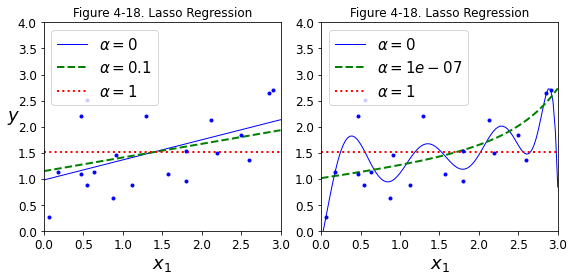

In [37]:
from sklearn.linear_model import Lasso #导入 Lasso 类

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('Figure 4-18. Lasso Regression') # 书中没有
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plt.title('Figure 4-18. Lasso Regression') # 书中没有
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

save_fig("lasso_regression_plot")
plt.show()

图4-18显示了与图4-17相同的内容,但用Lasso模型替换Ridge模型并使用较小的$α$值。

Lasso回归的一个重要特征是它倾向于完全消除最不重要特征的权重（即，将它们设置为零）。例如，图4-18右图中的虚线$(α= 10-7)$看起来是二次的，几乎是线性的：高次多项式特征的所有权重都等于零。换句话说，Lasso Regression自动执行特征选择并输出稀疏模型（即，具有很多零权重的特征）。

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [39]:
#这段代码，我也不是很清楚，写不了注释

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


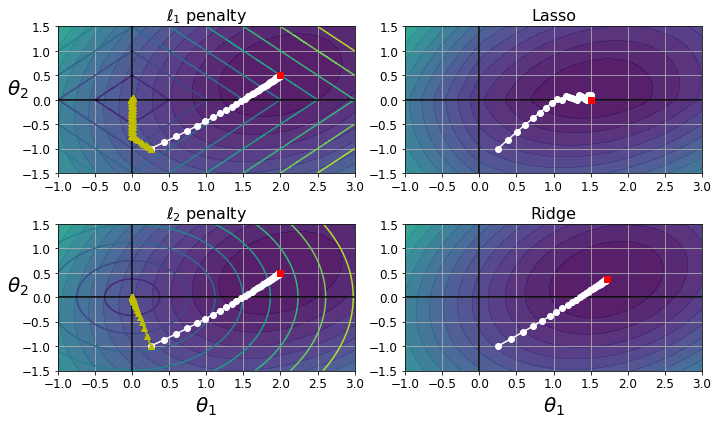

In [40]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(10, 6))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)
    
    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

save_fig("lasso_vs_ridge_plot")
plt.show()

通过查看图4-19(即上图)，你可以了解为什么会出现这种情况：
* 在左上图中，背景轮廓（椭圆）表示未经规范的MSE成本函数$(α= 0)$，白色圆圈表示具有该成本函数的批量梯度下降路径。 前景轮廓（菱形）代表$ℓ1$惩罚，三角形仅显示该惩罚的BGD路径$(α→∞)$。注意路径如何首先达到$θ_1= 0$，然后滚动沟谷直到达到$θ_2=0$.
* 在右上图中，轮廓表示相同的成本函数加上$l = 1$罚分，$α= 0.5$。全局最小值在$θ_2=0$轴上。 BGD首先达到$θ_2= 0$，然后滚动排水沟直到达到全局最小值。

两个底部的情况显示相同的东西，但使用$ℓ2$惩罚。 正则化的最小值比非正则化的最小值更接近$θ= 0$，但是权重没有被完全消除。

**注意**：在Lasso成本函数上，BGD路径趋向于向末端的沟谷反弹。 这是因为斜率在$θ_2=0$时发生突变。你需要逐渐降低学习速率，以便实际收敛到全局最小值。

在$θi=0$时，Lasso成本函数是不可微分的$(对于i = 1,2，...，n)$，但是当任何$θ_i=0$时，如果使用子梯度向量**g**，则梯度下降仍然可以正常工作。

公式4-11显示了一个子梯度向量方程，我们可以使用Grassient Descent和Lasso成本函数：

$g(\theta, J)=\nabla_{\theta} \operatorname{MSE}(\theta)+\alpha\left(\begin{array}{c}\operatorname{sign}\left(\theta_{1}\right) \\ \operatorname{sign}\left(\theta_{2}\right) \\ \vdots \\ \operatorname{sign}\left(\theta_{n}\right)\end{array}\right) \quad$ where sign $\left(\theta_{i}\right)=\left\{\begin{array}{cc}-1 & \text { if } \theta_{i}<0 \\ 0 & \text { if } \theta_{i}=0 \\ +1 & \text { if } \theta_{i}>0\end{array}\right.$

这是一个使用Lasso类的小型Scikit-Learn示例。请注意，你可以使用SGDRegressor(惩罚=“$l1”$)

In [41]:
from sklearn.linear_model import Lasso

lasso_reg=Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

#### 4.3.3 Elastic Net—弹性网

弹性网-Elastic Net是介于岭回归和Lasso回归之间的一种方法。 正则化项是Ridge和Lasso正则化项的简单组合，我们可以控制混合比率$r$。 当$r=0$时，弹性网相当于岭回归，当r = 1时，它相当于Lasso 回归（见公式4-12）:

$J(\theta)=\operatorname{MSE}(\theta)+r \alpha \sum_{i=1}^{n}\left|\theta_{i}\right|+\frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_{i}^{2}$

那么什么时候应该使用Linear Regression，Ridge，Lasso或Elastic Net？我们几乎总是优选至少有一点正则化的方法，所以通常你应该避免简单的线性回归。 Ridge是一个很好的默认值，但如果你怀疑只有少数特征实际上有用，你应该更喜欢Lasso或Elastic Net，因为它们倾向于将无用特征的权重降低到零，正如我们已经讨论过的那样。一般而言，Elastic Net优于Lasso，因为**当特征数量大于训练实例数或多个特征强相关时，Lasso可能表现不规律**。 

以下是使用Scikit-Learn的ElasticNet的简短示例（l1_ratio对应于混合比率$r$）：

In [42]:
from sklearn.linear_model import ElasticNet
elastic_net =ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([1.54333232])

#### 4.3.4 Early Stopping—早期停止发

一种非常不同的方法来规范迭代学习算法,例如Gradient Descent是在验证错误达到最小值后立即停止训练。这被称为 **Early Stopping**。 图4-20显示了一个复杂的模型（在这种情况下，高次多项式回归模型）使用批量梯度下降进行训练。

随着时期的推移，算法不断学习并且其在训练集上的**预测误差（RMSE）**自然下降，并且其在验证集上的预测误差也是如此。 但是，一段时间后，验证错误会停止减少并实际开始重新启动。**这表明该模型已开始过拟合训练数据**。 通过**Early Stopping**，我们只需在验证错误达到最小值后立即停止训练。 这是一种简单而有效的正规化技术，Geoffrey Hinton称之为“beautiful free lunch.”。

Saving figure early_stopping_plot


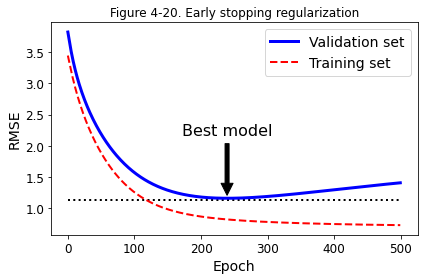

In [43]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,    #最多迭代1次
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # 只是为了让图好看
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title('Figure 4-20. Early stopping regularization') # 书中没有
save_fig("early_stopping_plot")
plt.show()

对于**Stochastic and Mini-batch 梯度下降**，曲线不是那么平滑，可能很难知道你是否达到了最小值。 一种解决方案是**仅在验证错误超过最小值一段时间后停止（当您确信模型不会做得更好时），然后将模型参数回滚到验证错误最小的点**。

下面是对Early Stoping 的一个基本实现：

In [44]:
from sklearn.base import clone

sgd_reg=SGDRegressor(max_iter=1,warm_start=True,penalty=None,learning_rate="constant",eta0=0.0005)

minimum_val_error=float("inf")
best_epoch=None
best_model=None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled,y_train) # continues where it left off
    y_val_predict=sgd_reg.predict(X_val_poly_scaled)
    val_error=mean_squared_error(y_val_predict,y_val)
    if val_error<minimum_val_error:   #判断是否满足提前结束条件
        minimum_val_error=val_error
        best_epoch=epoch
        best_model=clone(sgd_reg)

In [45]:
best_epoch,best_model

(227,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              warm_start=True))

请注意，使用warm_start = True，调用fit（）方法时，它只是继续训练，而不是从头开始重新开始。

### 4.4 Logistic Regression—逻辑回归

正如我们在第1章中讨论的那样，一些回归算法也可用于分类（反之亦然）。**Logistic回归（也称为Logit回归）通常用于估计实例属于特定类的概率**（例如，此电子邮件是垃圾邮件的概率是多少？）。
* 如果估计的概率大于50％，则模型预测实例属于该类（称为正类，标记为“1”）
* 否则它预测它不属于（即，它属于负类 ，标记为“0”）。 

这使它成为二元分类器。

那么它是怎样工作的？ 就像线性回归模型一样,Logistic回归模型**计算输入特征的加权和（加上偏差项）**，但不是像线性回归模型那样直接输出结果，而是输出该结果的**logistic**（见公式4-13）：


公式 4-13  Logistic回归模型估计概率（向量形式）

$\widehat{p} = h_{\theta}(\mathbf{x}) = \sigma(\mathbf{x}^{T}\mathbf{\theta})$

logistic - 也称为logit，记为$σ(·)$ - 是一个S函数（即S形）输出**0到1之间的数字**。其定义如公式4-14和图4-21所示:

公式 4-14 Logistic 函数：

$\sigma (t) = \frac{1}{1 + \text{exp}(-t)}$

Saving figure logistic_function_plot


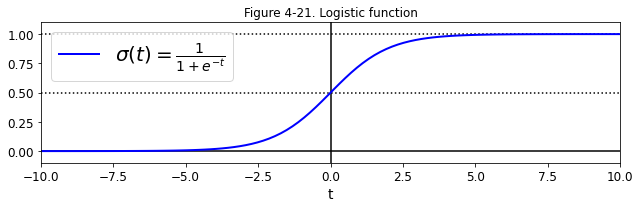

In [46]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.title('Figure 4-21. Logistic function')
save_fig("logistic_function_plot")
plt.show()

一旦Logistic回归模型估计出实例x概率$p =h_θ(x)$，它可以很容易地进行预测（见公式4-15）:

公式 4-15 Logistic 回归模型预测：

$\hat{y}=\left\{\begin{array}{l}0 \text { if } \hat{p}<0.5 \\ 1 \text { if } \hat{p} \geq 0.5\end{array}\right.$

注意:
* 当 $t < 0$ 时 $σ(t)< 0.5 $，
* 当 $t ≥ 0 $时 $σ(t)≥ 0.5 $，

所以对于Logistic回归，
* 如果$θ^T·x$是正数,模型预测结果就是 1，
* 如果是负数，则预测结果是 0 。

分数$t$被称为 logit。这个名字来自 logits 函数：$\text{logit}(p) = \text{log}(p/(1-p))$是 logistic 函数的逆函数。它是正类的估计概率和负类的估计概率之比的对数。

#### 4.4.2 Training and Cost Function—训练和成本函数

现在我们知道Logistic回归模型如何估计概率和做出预测了。 但它是如何训练的呢？ **训练的目的是设置参数向量$θ$**， 使得模型:

* 对于正实例（y = 1）估计得到高概率
* 对于负实例估计得到低概率（y = 0）。

对于单个训练实例 $\mathbf{x}$，该想法由等式4-16中所示的成本函数表达：

公式 4-16 一个实例的成本函数

$c(\theta)=\left\{\begin{array}{cc}-\log (\hat{p}) & \text { if } y=1 \\ -\log (1-\hat{p}) & \text { if } y=0\end{array}\right.$

这个成本函数是有道理的因为:
* 当 $t$ 接近0时，$-log(t)$会变得非常大，所以如果模型估计正实例的概率接近于0，则成本会很大，如果模型估计负实例的概率接近1，它也将非常大。
* 另一方面，当t接近1时， $-log(t)$接近于0，因此如果估计概率接近 0 表示**负实例**, 接近1表示**正例**，这样**损失函数将接近0**， 而这正是我们想要的。

整个训练集的成本函数只是所有训练实例的平均成本。它可以写成单个表达式（你可以轻松验证），称为**对数损失**，如公式4-17所示：

公式 4-17 Logistic 回归成本函数（log loss）：

$J(\theta)=-\frac{1}{m} \sum_{i=1}^{m}\left[y^{(i)} \log \left(\hat{p}^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-\hat{p}^{(i)}\right)\right]$

坏消息是没有已知的封闭式方程式计算最小化此成本函数的 $θ$ 值（没有等效的Normal Equation）. 但**好消息是**，这个成本函数**是凸**的，所以**Gradient Descent（或任何其他优化算法）能保证找到全局最小值**（如果学习率不是太大，你等待的时间也足够长）。

关于第 $j$ 个模型参数 $θ_j$ 的成本函数的偏导数由等式4-18给出:

公式 4-18 Logistic 成本函数的偏导数：

$\frac{\partial}{\partial \theta_{j}} \mathrm{J}(\theta)=\frac{1}{m} \sum_{i=1}^{m}\left(\sigma\left(\theta^{T} \cdot \mathbf{x}^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)}$

这个等式看起来非常像公式4-5：
* 对于每个实例，它计算预测误差并将其乘以第 $j$ 个特征值，然后计算所有训练实例的平均值。
* 一旦得到包含所有偏导数的梯度向量，就可以在Batch Gradient Descent算法中使用它。

就是这样：你现在知道如何训练Logistic回归模型。
* 对于Stochastic GD，我们只需要一次执行一个实例，
* 对于Mini-batch GD，我们可以一次使用一个小的批量。

#### 4.4.3 Decision Boundaries

让我们使用鸢尾花数据集来说明Logistic回归。这是一个着名的数据集，包含萼片和花瓣的长度和宽度为150的三种不同品种的鸢尾花：**Iris-Setosa，Iris-Versicolor和Iris-Virginica**（见图4-22）。
![image-20200720111931674](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202007/20/111950-5591.png)

让我们尝试构建一个**分类器**来检测Iris-Virginica类型仅基于花瓣宽度特征。 首先让我们加载数据：

In [47]:
from sklearn import datasets
iris=datasets.load_iris()   #获取训练数据
list(iris.keys())   

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [48]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [49]:
X=iris["data"][:,3:] # 找到对应的数据
y=(iris["target"]==2).astype(np.int)# 1 if Iris-Virginica, else 0

下面训练一个Logistic Regression model:

In [50]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression()
log_reg.fit(X,y) #y 的维度为 150

LogisticRegression()

让我们来看看模型估计的花瓣宽度从0到3厘米变化的概率（图4-23）：

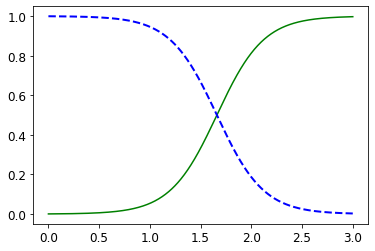

In [51]:
X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new) # y-proba包含两个类的概率
# print(y_proba.shape)
plt.plot(X_new,y_proba[:,1],"g-",label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")

书上的图更为精致：

Saving figure logistic_regression_plot


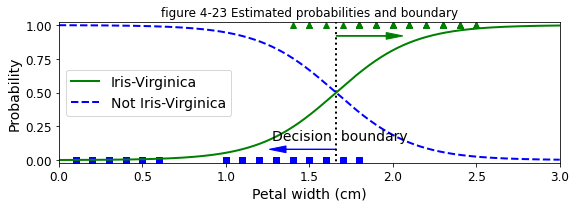

In [52]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]  #找到负类概率大于0.5的点，即为分界点

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.title('figure 4-23 Estimated probabilities and boundary')
save_fig("logistic_regression_plot")
plt.show()

鸢尾 - 弗吉尼亚花的花瓣宽度（以三角形表示）的范围为1.4厘米至2.5厘米，而其他鸢尾花（由方块表示）通常有一个宽度较小，范围从0.1厘米到1.8厘米的花瓣。请注意，这里还是有一些重叠的。
* 在大约2厘米以上的范围，分类器非常有信心确定这个花是一个Iris-Virginica（它输出该类的概率很高），
* 在低于1厘米时，分类器非常有信心确定它不是Iris-Virginica（不是“鸢尾 - 维吉尼卡”级别的概率很高）。

在这些极端之间，分类器是不确定的。但是，如果您要求它预测类（使用**predict（）**方法而不是**predict_proba（）**方法），它将返回最可能的类。因此，在**1.6厘米**处存在决策边界，其中两个概率均等于50％：
* 如果花瓣宽度高于1.6厘米，分类器将预测花是鸢尾 - 弗吉尼亚，
* 或者它将预测它不是（即使它不是很自信）：

In [53]:
decision_boundary

array([1.66066066])

In [54]:
log_reg.predict([[1.7],[1.5]])  #决策边界的两边，输出的类完全不一样

array([1, 0])

Saving figure logistic_regression_contour_plot


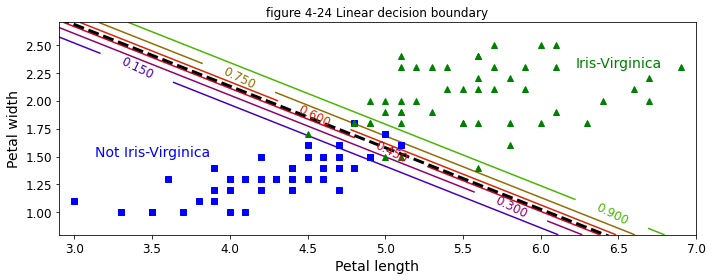

In [55]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # 花瓣长度和宽度
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )   # 和 matlab 一样，生成网格
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
# 找到边界
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.title('figure 4-24 Linear decision boundary')
save_fig("logistic_regression_contour_plot")
plt.show()

图4-24显示了相同的数据集，但这次显示了两个特征：**花瓣宽度和长度**。 一旦经过训练，Logistic回归分类器就可以基于这两个特征来估计新花是Iris-Virginica的概率。虚线表示模型估计50％概率的点：这是模型的决策边界。 请注意，它是一个**线性边界**。每条平行线代表模型输出特定概率的点，从15％（左下）到90％（右上）。 根据模型，超越右上方的所有花朵都有超过90％的机会成为Iris-Virginica。

与其他线性模型一样，Logistic回归模型可以使用$ℓ1$或$ℓ2$惩罚进行正则化。 Scitkit-Learn实际上默认增加了$ℓ2$惩罚项。控制Scikit-Learn LogisticRegression模型正则化强度的超参数不是alpha（如在其他线性模型中），而是其反函数：**C。 C值越高，模型的正则化程度越低**。

#### 4.4.4 Softmax Regression —softmax回归

Logistic回归模型可以推广到直接支持多个类，而无需训练和组合多个二元分类器（如第3章所述）。这称为**Softmax回归，或多项Logistic回归**。 这个想法非常简单：
* 当给定一个实例x时，Softmax回归模型首先计算每个类 k 的得分$s_k(x)$，
* 然后通过将softmax函数（也称为归一化指数）应用于这个分数来估计每个类的概率。

计算$s_k(x)$的公式应该看起来很熟悉，因为它就像线性回归预测的公式（见公式4-19）:

公式 4-19 类别 k 的 Softmax 分数：

$s_{k}(\mathbf{x}) = \mathbf{x}^{T}\mathbf{\theta}^{(k)}$

注意，每个类具有其自己的专用参数矢量$θ^{(k)}$。 所有这些矢量通常作为**行**存储在参数矩阵$Θ$中。一旦计算了实例 $\mathbf{x}$ 的每个类的得分，就可以通过softmax函数运行得分来估计实例属于类 k 的概率 $\widehat{p}_k$（公式4-20）：它计算每个得分的指数， 然后将它们归一化（除以所有指数的总和）

公式 4-20 Softmax 函数：

$\hat{p}_{k}=\sigma(\mathbf{s}(\mathbf{x}))_{k}=\frac{\exp \left(s_{k}(\mathbf{x})\right)}{\sum_{j=1}^{K} \exp \left(s_{j}(\mathbf{x})\right)}$
* $K$ 为类别总数
* $\mathbf{s}(\mathbf{x})$ 为一个包含实例 $\mathbf{x}$ 的每个类的分数的向量
* $σ(s(x))_k$ 是实例 $x$ 属于类 k 的估计概率，给出该实例的每个类的分数。

就像Logistic回归分类器一样，Softmax回归分类器可以预测具有最高估计概率的类（这只是得分最高的类），如公式 4-21 所示。

公式 4-21 Softmax 回归分类器：

$\hat{y}=\underset{k}{\operatorname{argmax}} \sigma(\mathbf{s}(\mathbf{x}))_{k}=\underset{k}{\operatorname{argmax}} s_{k}(\mathbf{x})=\underset{k}{\operatorname{argmax}}\left(\left(\theta^{(k)}\right)^{T} \mathbf{x}\right)$

* argmax运算符返回最大化函数的变量的值。在该等式中，它返回最大化估计概率$σ(s(x))_k$的 k 值

Softmax回归分类器**一次只预测一个类（即，它是多类，而不是多输出）**，因此它应该**仅用于互斥类**，例如不同类型的植物。 你不能使用它来识别一张图片中的多个人。

现在我们已了解模型如何估计概率并进行预测，下面我们来看看训练。目标是建立一个模型对目标类估计出高概率（因此其他类的概率很低）。最小化公式4-22中所示的成本函数**（称为交叉熵）**应该可以达到这个目标，因为它在估计目标类的低概率时会对模型进行惩罚。**交叉熵经常用于衡量一组估计类的概率与目标类别的匹配程度（我们将在接下来的章节中多次使用它）**：!

公式 4-22 交叉熵成本函数：

$J(\boldsymbol{\Theta})=-\frac{1}{m} \sum_{i=1}^{m} \Sigma_{k=1}^{K} y_{k}^{(i)} \log \left(\hat{p}_{k}^{(i)}\right)$
* 如果第 $i$ 个实例的目标类是 k，则$y_k^{(i)}$等于1;否则，它等于0。

请注意，当只有两个类（K = 2）时，**此成本函数等效于Logistic回归的成本函数**（对数损失;请参见公式4-17）。

**交叉熵**
交叉熵源于信息论。假设您希望每天有效地传输有关天气的信息。 如果有八个选项（晴天，下雨等），每个选项您可以使用3位编码，因为$2^3 = 8$。但是，如果你认为它几乎每天都是晴天，那么在一个比特（0）上编码“晴天”和在4个比特上编码其他七个选项（从1开始）会更有效。交叉熵测量每个选项实际发送的平均位数。 如果你对天气的假设是完美的，那么交叉熵就等于天气本身的熵（即其内在的不可预测性）。但是如果你的假设是错误的（例如，如果经常下雨），交叉熵将会更大，称为**Kullback-Leibler分歧**。

两个概率分布 **p** 和 **q** 之间的交叉熵定义为$H(p,q) = - Σ_xp(x)logq(x)$（至少当分布是离散的时）。

该成本函数(4-22)关于$θ_k$的梯度向量由公式4-23给出：

公式 4-23 类别 $k$ 的交叉熵梯度向量：

$\nabla_{\theta^{(k)}} J(\mathbf{\Theta})=\frac{1}{m} \sum_{i=1}^{m}\left(\hat{p}_{k}^{(i)}-y_{k}^{(i)}\right) \mathbf{x}^{(i)}$

现在我们可以计算每个类的梯度向量，然后使用梯度下降（或任何其他优化算法）以找到最小化成本函数的参数矩阵$Θ$。

让我们使用Softmax回归将鸢尾花分为三类。当我们在两个以上的类上训练时，Scikit-Learn的LogisticRegression默认使用一对一，但您可以将multi_class超参数设置为**“多项”**以将其切换为Softmax回归。 您还必须指定支持Softmax回归的解算器，例如“lbfgs”求解器（有关详细信息，请参阅Scikit-Learn的文档）。默认情况下它也适用于ℓ2正则化，你可以使用超参数C进行控制：

In [56]:
X=iris["data"][::,(2,3)]  # 花瓣长度和宽度
y=iris["target"]

softmax_reg=LogisticRegression(multi_class="multinomial",solver="lbfgs",C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

所以下次你找到一个5厘米长，2厘米宽的花瓣，你可以让你的模型告诉你它是什么类型的鸢尾花，它会回答Iris-Virginica（2级）的概率为94.2％（或者Iris-Versicolor概率为5.8％）：

In [57]:
softmax_reg.predict([[5, 2]]) # 输出为2，实际为第三类，因为从0开始计算

array([2])

In [58]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

Saving figure softmax_regression_contour_plot


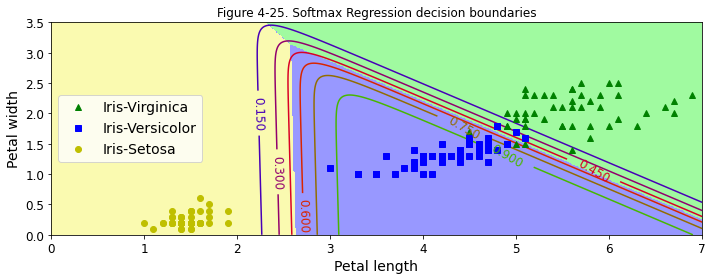

In [59]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.title('Figure 4-25. Softmax Regression decision boundaries')
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

图4-25显示由**背景颜色**表示的结果**决策边界**。 请注意，任何两个类之间的决策边界是**线性**的。该图还显示出了由曲线表示的Iris-Versicolor类的概率（例如，标记为0.450的线表示45％概率边界）。 请注意，模型可以预测估计概率低于50％的类。例如，在所有决策边界相遇的地方，所有类别的估计概率均为33％